In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import liana as li

In [2]:
import muon as mu
import plotnine as p9
import mofax as mofa

/home/dbdimitrov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
INVERSE_FUN = lambda x: -np.log10(x)
groupby = 'cell_type_original' # NOTE: the same cell types but readable; TODO abbvreviate this garbage
sample_key = 'sample'
condition_key = 'patient_group'

In [4]:
resource = pd.read_csv(os.path.join('results', 'lr_pairs.csv'))
cell_pairs = pd.read_csv(os.path.join('results', 'cell_pairs.csv'))

In [5]:
resource = resource[resource['top1std']]

Run LIANA + MOFA

In [6]:
adata = sc.read_h5ad(os.path.join('results', 'kuppe_processed.h5ad'), backed='r')

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [7]:
liana_res = adata.uns['liana_res']

In [8]:
liana_res[(liana_res['ligand_complex']=='SPP1') &
          (liana_res['receptor_complex']=='ITGA5_ITGB1') &
          (liana_res['source']=='FB') & 
          (liana_res['target']=='MY')
          ].sort_values(["ligand_complex", 'receptor_complex']).head(50)

,sample,source,target,ligand_complex,receptor_complex,lr_means,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,magnitude_rank
20735,CK160,FB,MY,SPP1,ITGA5_ITGB1,0.154187,0.022611,-0.090755,-0.131080,0.014300,0.553414,0.796796
46203,CK164,FB,MY,SPP1,ITGA5_ITGB1,0.234019,0.050953,-0.077854,-0.135509,0.020017,0.651281,1.000000
95298,CK361,FB,MY,SPP1,ITGA5_ITGB1,0.137860,0.018840,-0.016930,0.020664,0.022049,0.524870,0.354991
119849,CK363,FB,MY,SPP1,ITGA5_ITGB1,0.197250,0.037405,-0.000090,-0.007797,0.023235,0.558619,1.000000
134032,CK365,FB,MY,SPP1,ITGA5_ITGB1,0.229178,0.052202,-0.172383,-0.844221,0.012617,0.613301,1.000000
183615,CK371,FB,MY,SPP1,ITGA5_ITGB1,0.433958,0.103047,-0.121667,-0.404867,0.014974,0.693041,0.888612
195297,CK373,FB,MY,SPP1,ITGA5_ITGB1,0.660545,0.270724,-0.085937,-0.291744,0.020571,0.782524,0.672783
213324,CK376,FB,MY,SPP1,ITGA5_ITGB1,0.154486,0.023853,-0.144053,-0.722449,0.005268,0.586525,0.102497


In [9]:
mdata = li.multi.lrs_to_views(adata,
                              score_key='magnitude_rank',
                              inverse_fun=INVERSE_FUN,
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.2, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 15, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 20, # minimum number of interactions to keep a view
                              samples_per_view = 10, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0, # fill missing LR values across samples with this
                              verbose=True
                              )

100%|██████████| 24/24 [00:00<00:00, 45.96it/s]


In [10]:
outfile = os.path.join('results', 'models', 'mofatalk.h5ad')

In [11]:
model = mu.tl.mofa(mdata,
                   use_obs='union',
                   outfile=outfile,
                   seed=1337,
                   n_factors=10,
                   convergence_mode='slow',
                   scale_views=True,
                #    copy=True
                )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Scaling views to unit variance...

Loaded view='CM&CM' group='group1' with N=28 samples and D=498 features...
Loaded view='EN&CM' group='group1' with N=28 samples and D=469 features...
Loaded view='CM&FB' group='group1' with N=28 samples and D=459 features...
Loaded view='FB&CM' group='group1' with N=28 samples and D=488 features...
Loaded view='CM&PC' group='group1' with N=28 samples and D=459 features...
Loaded view='CM&EN' group='group1' with N=28 samples and D=474 features...
Loaded view='FB&EN' group='group1' with N=28 samples and D=467 features...
Loaded view='PC&CM' group='group1' with N=28 samples and D=464 features...
Loaded view='FB&PC' group='group1' with N=28 samples and D=453 features...
Loaded view='FB&MY' group='group1' with N=28 samples and D=472 features...
Loaded view='FB&VM' group='group1' with N=28 samples and D=484 features...
Loaded view='FB&FB' group='group1' with N=28 samples and D=464 features...
Loaded view='EN&VM' group='group1' with N=28 samples and D=459 fe

In [12]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=condition_key)
factor_scores.head()

,sample,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,patient_group
0,CK158,-2.231643,0.410272,-0.249517,-0.044318,-0.084283,-0.177150,-0.048314,-0.054989,-0.048194,-1.090337,myogenic
1,CK159,-1.202353,0.566966,-0.267826,-0.047057,-0.104635,-0.162740,-0.038433,-0.067883,-0.069560,0.060378,myogenic
2,CK160,0.098812,-0.261791,-0.232389,-0.048545,-0.005892,-0.143183,-0.059862,-0.061894,-0.045579,0.061213,myogenic
3,CK162,0.325380,0.467719,-0.319689,-0.050351,-0.091127,-0.164858,-0.041326,1.685303,-0.060114,0.061264,fibrotic
4,CK163,-1.787903,0.530565,-0.467263,-0.046703,-0.087663,-0.155852,-0.043481,-0.064952,-0.059354,0.050358,myogenic


In [13]:
model = mofa.mofa_model(outfile)
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 28
Features: 11049
Groups: group1 (28)
Views: CM&CM (498), CM&EN (474), CM&FB (459), CM&PC (459), EN&CM (469), EN&EN (449), EN&FB (436), EN&PC (432), EN&VM (459), FB&CM (488), FB&EN (467), FB&FB (464), FB&MY (472), FB&PC (453), FB&VM (484), MY&FB (433), MY&MY (447), PC&CM (464), PC&EN (448), PC&FB (435), PC&PC (429), VM&EN (473), VM&FB (467), VM&VM (490)
Factors: 10
Expectations: W, Z

Explore Results

In [14]:
factor_of_interest = "Factor1"

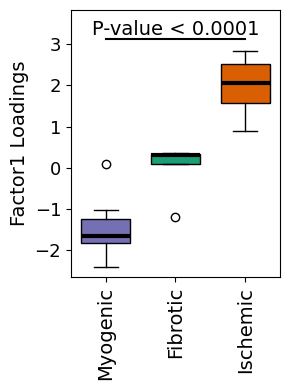

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway

# Assuming factor_scores is your DataFrame and condition_key is the column for conditions
factor_scores[condition_key] = factor_scores[condition_key].str.title().astype('category')
labels = ['Myogenic', 'Fibrotic', 'Ischemic']

# Set the color palette and style
colors = ['#7570b3', '#1b9e77', '#d95f02']

# Create a boxplot
plt.figure(figsize=(3, 4))
box_positions = np.arange(1, len(labels) + 1)

max_y = float('-inf')
min_y = float('inf')

for i, label in enumerate(labels):
    subset = factor_scores[factor_scores[condition_key] == label][factor_of_interest]
    plt.boxplot(subset, positions=[box_positions[i]], widths=0.7, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black', linewidth=3))
    max_y = max(max_y, max(subset))
    min_y = min(min_y, min(subset))

# Perform one-way ANOVA
groups = [factor_scores[factor_scores[condition_key] == group][factor_of_interest] for group in labels]
statistic, p_value = f_oneway(*groups)

pval = round(p_value, 3)

# Add comparison lines and p-value
y = max_y + 0.1 * max_y  # adjust 0.05 to change the height of the comparison lines
plt.plot([1, 3], [y, y], color='k')
plt.text(2, y, f'P-value < {pval+ 0.0001:.4f}', ha='center', va='bottom', size=14)

# extend y axis
plt.ylim(min_y*1.1, max_y + 0.35 * max_y)

# Set labels and title
plt.xlabel('')
plt.ylabel(f'{factor_of_interest} Loadings', fontsize=14)
plt.title('')
plt.xticks(box_positions, labels, fontsize=14, rotation=90) 
plt.yticks(fontsize=13)
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join('..', '..', 'figures', 'Fig3I.pdf'), dpi=300)

In [17]:
factor_scores.to_csv(os.path.join("..", "..", "figures", "source", "Fig3I.csv"))

In [18]:
variable_loadings =  li.ut.get_variable_loadings(mdata,
                                                 varm_key='LFs',
                                                 view_sep=':',
                                                 pair_sep="&",
                                                 variable_sep="^") # get loadings for factor 1
variable_loadings.head()

# here we will just assign the size of the dots, but this can be replace by any other statistic
variable_loadings['size'] = 4.5



In [19]:
variable_loadings.to_csv(os.path.join('results', 'kuppe_mofa_loadings.csv'))

In [20]:
my_plot = li.pl.dotplot(liana_res = variable_loadings,
                        size='size',
                        colour=factor_of_interest,
                        orderby=factor_of_interest,
                        # ligand_complex=["FN1", 'TNC', 'THBS1', 'SPP1'],  # 'NAMPT', 
                        top_n=15,
                        orderby_absolute=False,
                        orderby_ascending=False,
                        size_range=(0.1, 4),
                        figure_size=(14, 7)
                        )
# change colour, with mid as white
my_plot = (my_plot + p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0) + 
           # make all text labels larger size > 15
           p9.theme(axis_text_x=p9.element_text(size=15),
                    axis_text_y=p9.element_text(size=14),
                    text=p9.element_text(size=15),
                    axis_title=p9.element_text(size=17, color='gray', weight='bold'),
                    legend_title=p9.element_text(size=17),
                    legend_text=p9.element_text(size=16),
                    strip_text=p9.element_text(size=15)
                    ) +
           # hide size legend
              p9.guides(size=False) +
              # legend label to 'Factor 1 Loadings'
              p9.labs(color='Factor 1\nLoadings\n')
           
           
           )
my_plot.save(os.path.join('..', '..', 'figures', 'sufig_heartC.pdf'))

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


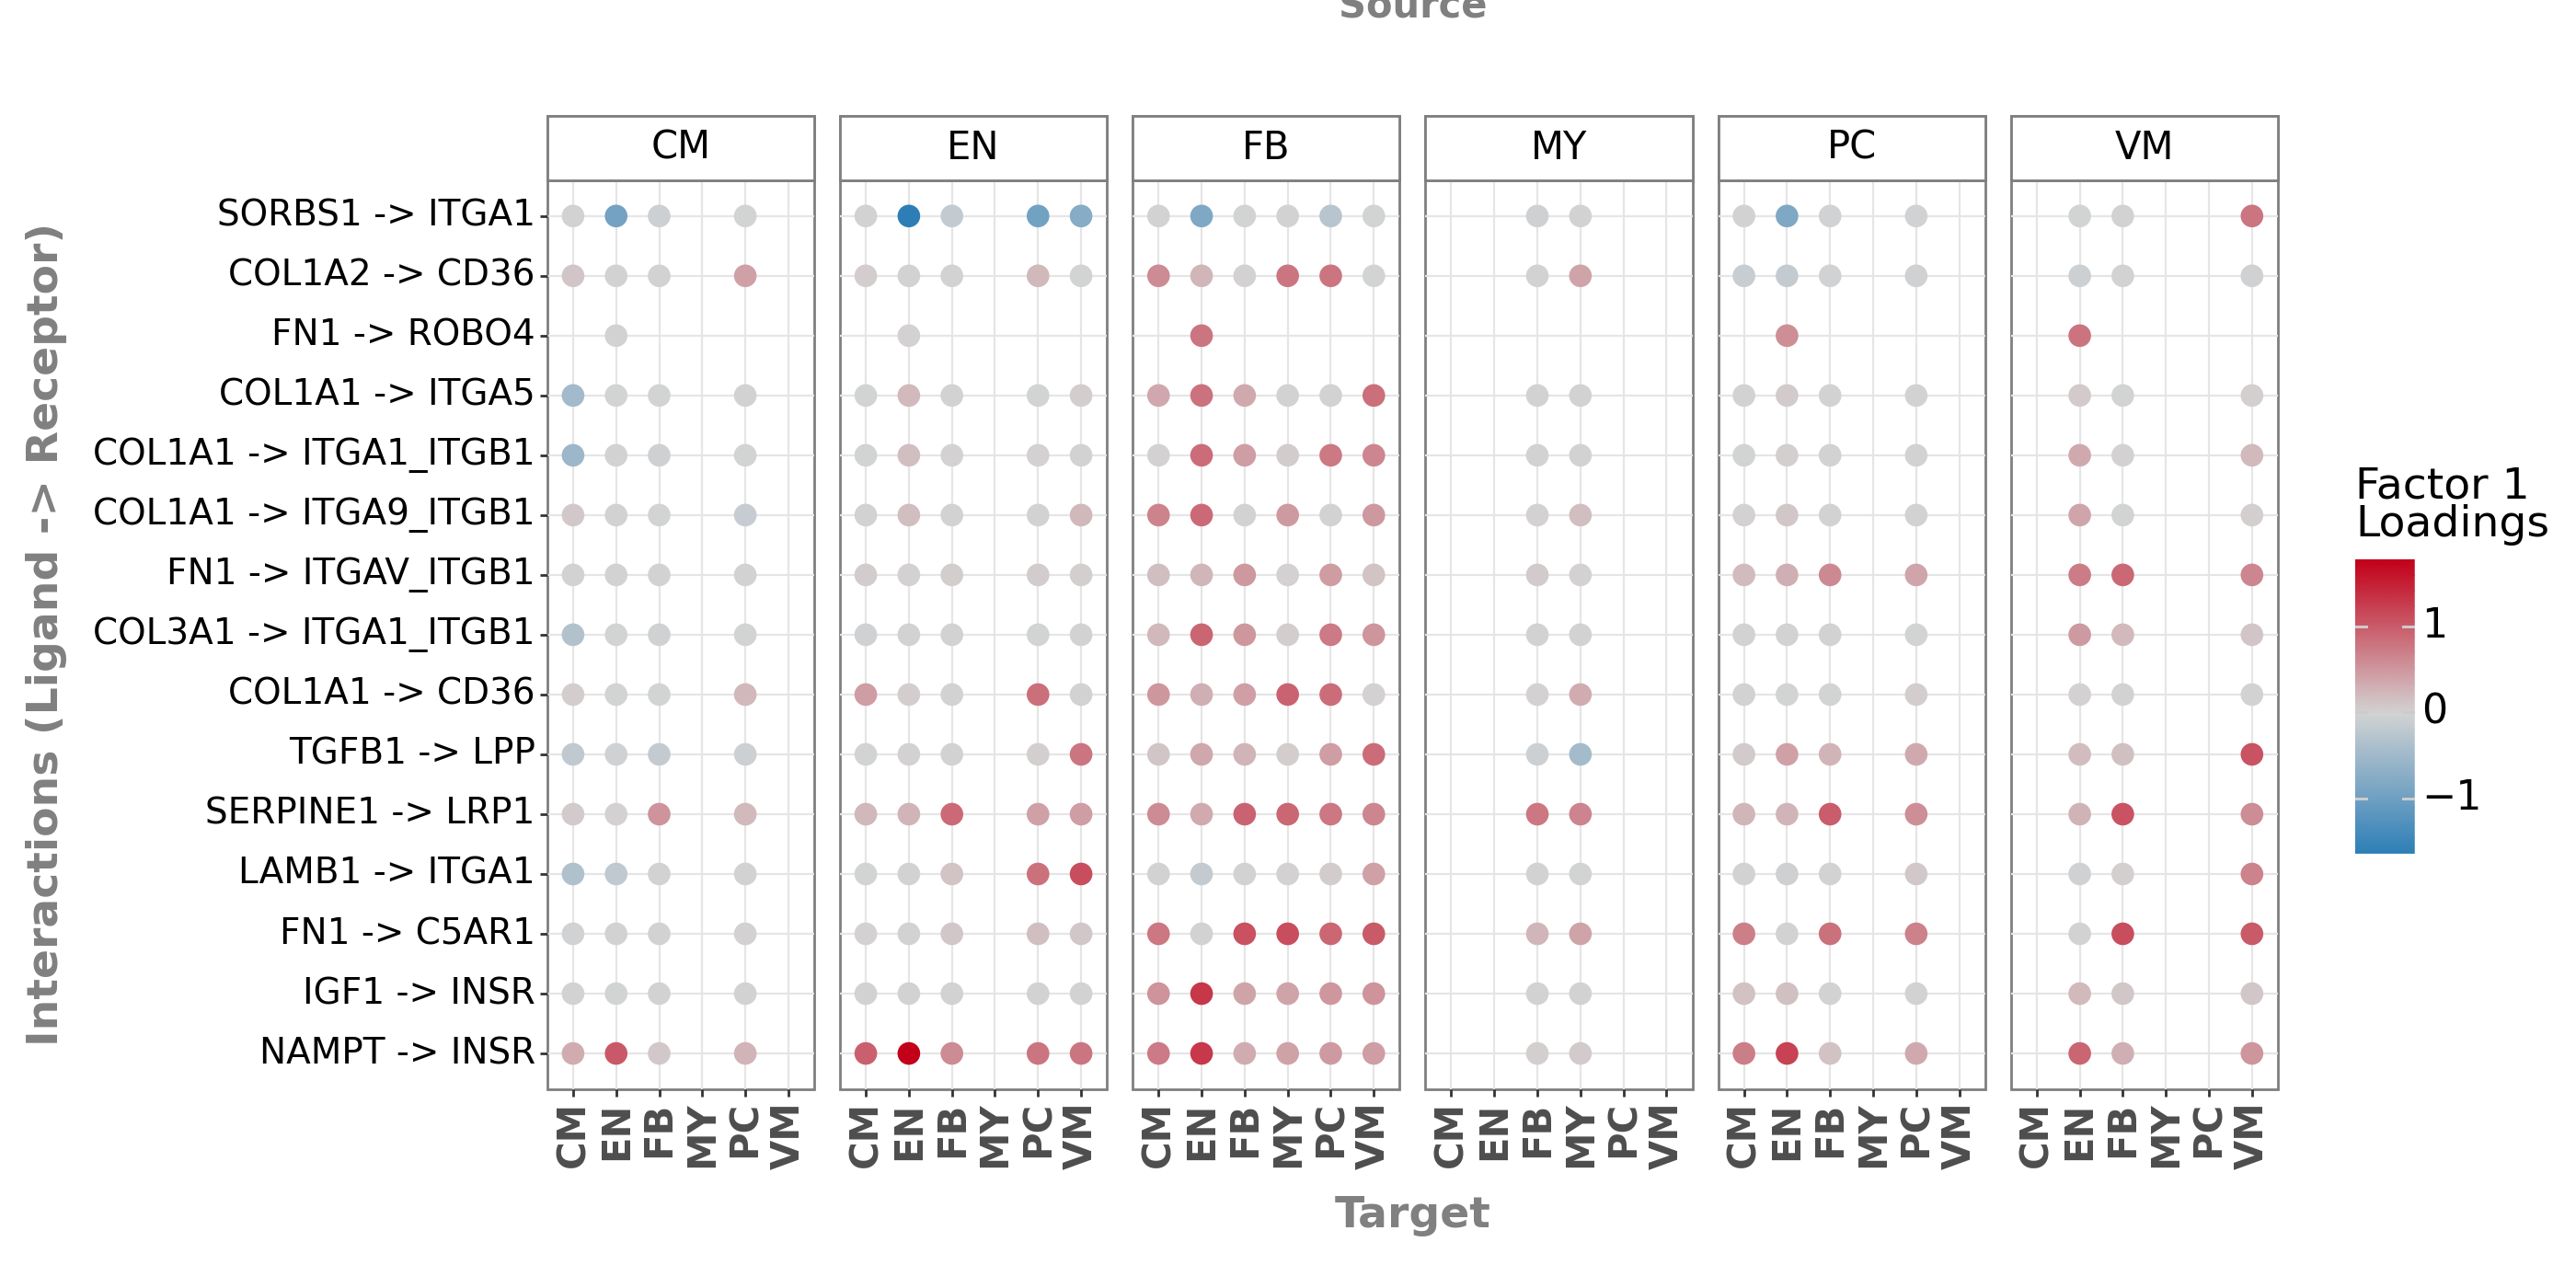

<Figure Size: (1400 x 700)>

In [21]:
my_plot

In [23]:
my_plot.data.to_csv(os.path.join("..", "..", "figures", "source", "Sufig9C.csv"))

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


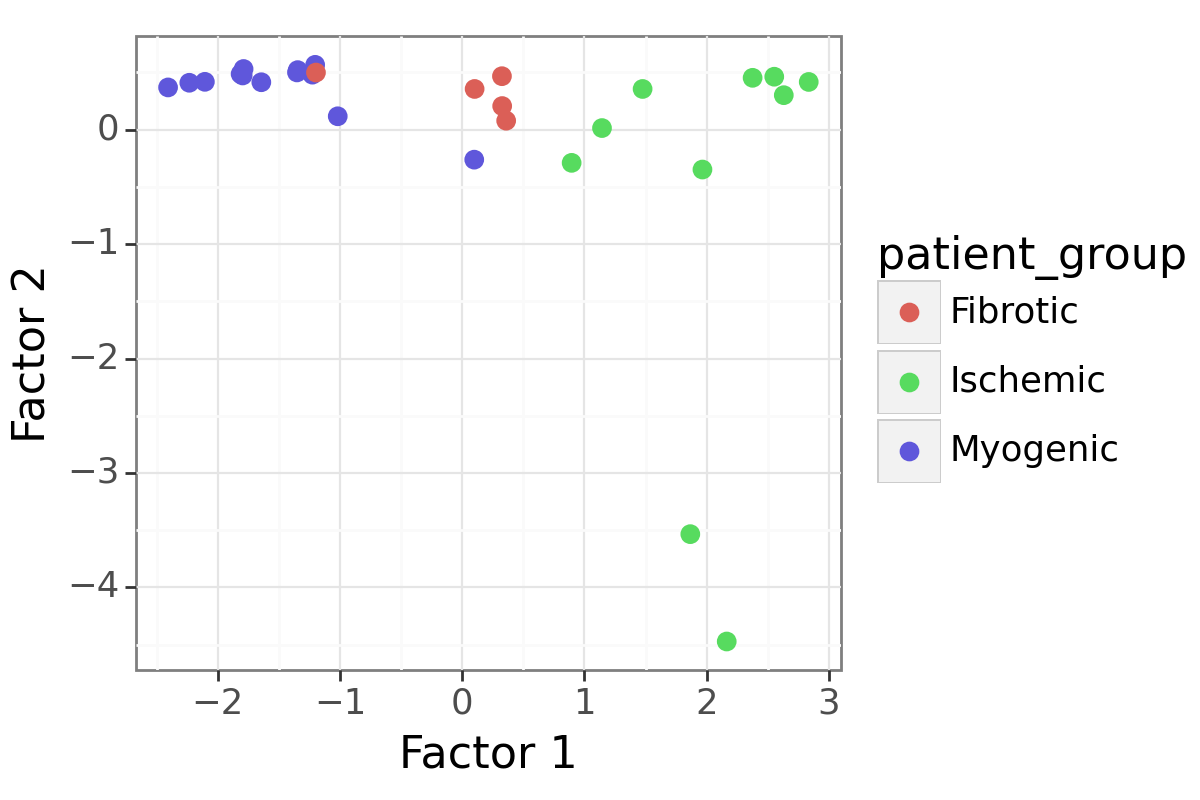

<Figure Size: (600 x 400)>

In [24]:
# dotplot of Factor1 (x) and Factor2 (y)
(
    p9.ggplot(factor_scores) +
    p9.aes(x='Factor1', y='Factor2', colour=condition_key) +
    p9.geom_point(size=3) +
    p9.theme_bw(base_size=16) +
    p9.theme(figure_size=(6, 4)) +
    p9.labs(x='Factor 1', y='Factor 2')
)

Factor 1 R2 per view

In [25]:
# get variance explained by view and factor
rsq = model.get_r2()
factor_rsq = rsq[rsq['Factor']==factor_of_interest]
# separate view column
factor_rsq[['source', 'target']] = factor_rsq['View'].str.split('&', 1, expand=True)

In [26]:
# Remove adipocyte as it does not explain much
factor_rsq = factor_rsq[~((factor_rsq['source'] == 'Adipocyte') | (factor_rsq['target'] == 'Adipocyte'))]

In [27]:
factor_rsq.sort_values("R2", ascending=False).head(15)

,Factor,View,Group,R2,source,target
6,Factor1,FB&EN,group1,29.712700,FB,EN
8,Factor1,FB&PC,group1,28.021636,FB,PC
9,Factor1,FB&MY,group1,25.053327,FB,MY
16,Factor1,EN&EN,group1,24.129950,EN,EN
17,Factor1,PC&PC,group1,23.982331,PC,PC
11,Factor1,FB&FB,group1,23.676703,FB,FB
15,Factor1,EN&PC,group1,23.227447,EN,PC
19,Factor1,EN&FB,group1,21.681604,EN,FB
22,Factor1,PC&EN,group1,21.478706,PC,EN
10,Factor1,FB&VM,group1,20.798195,FB,VM


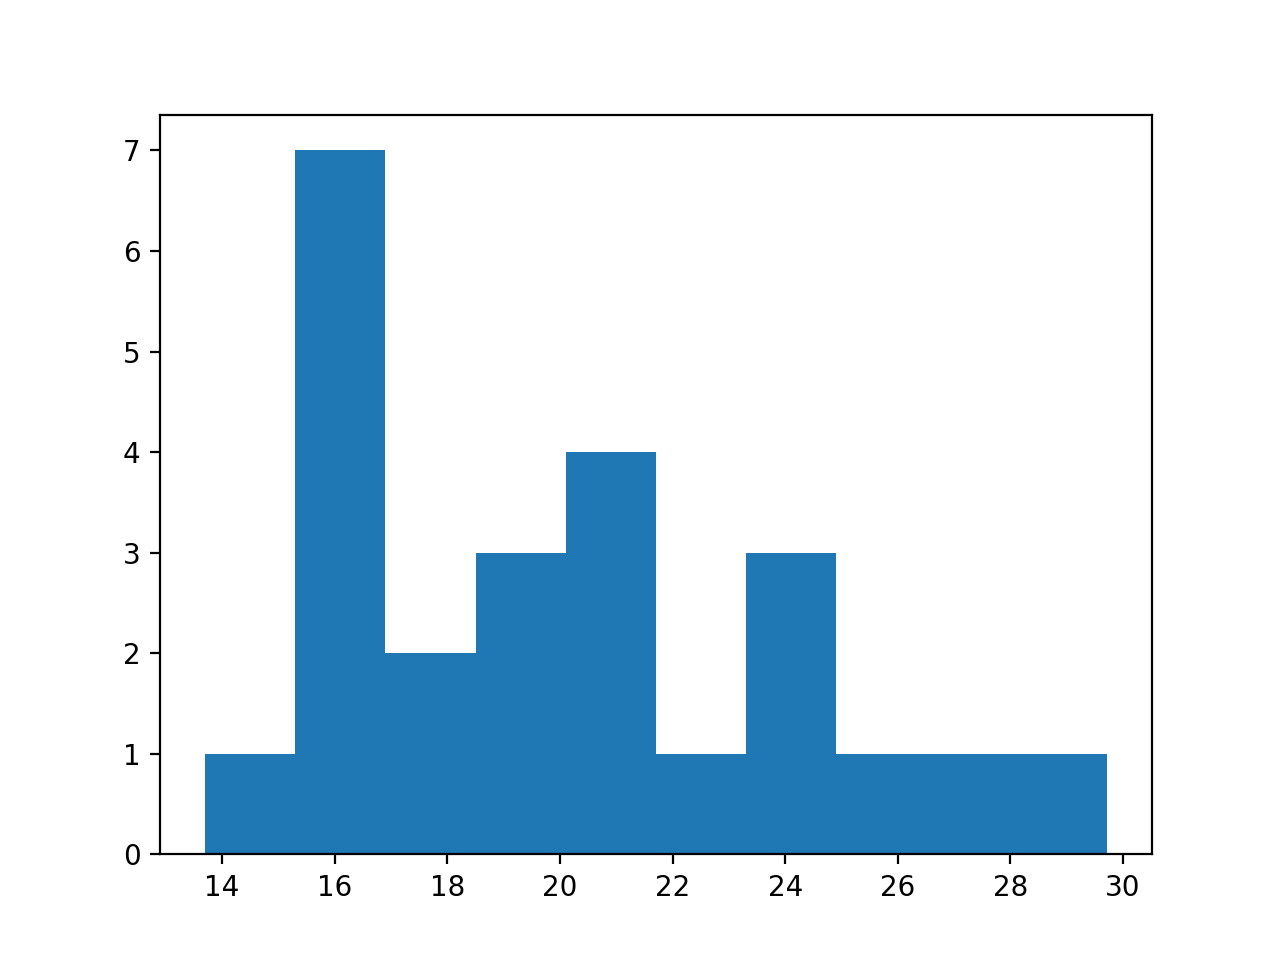

In [28]:
plt.hist(factor_rsq['R2']);

In [29]:
factor_rsq['source'] = factor_rsq['source'].astype('category')
factor_rsq['target'] = factor_rsq['target'].astype('category')

In [30]:
my_plot = (p9.ggplot(factor_rsq.reset_index()) +
 p9.aes(x='target', y='source') +
 p9.geom_tile(p9.aes(fill='R2')) +
 # geom text
    p9.geom_text(p9.aes(label='round(R2, 1)'), size=23, color='white') +
    p9.scale_fill_gradient2(limits=(0, 35)) +
 p9.theme_bw(base_size=22) +
 p9.labs(x='Target', y='Source', fill='R²') +
 p9.theme(axis_text_x=p9.element_text(rotation=90, size=25),
          figure_size=(7.5, 6), 
          axis_text_y=p9.element_text(size=25),
          axis_title=p9.element_text(size=25),
          legend_text=p9.element_text(size=25),
          legend_text_colorbar=p9.element_text(size=25),
          
          )
)
my_plot
my_plot.save(os.path.join('..', '..', 'figures', 'Fig3J.pdf'))

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


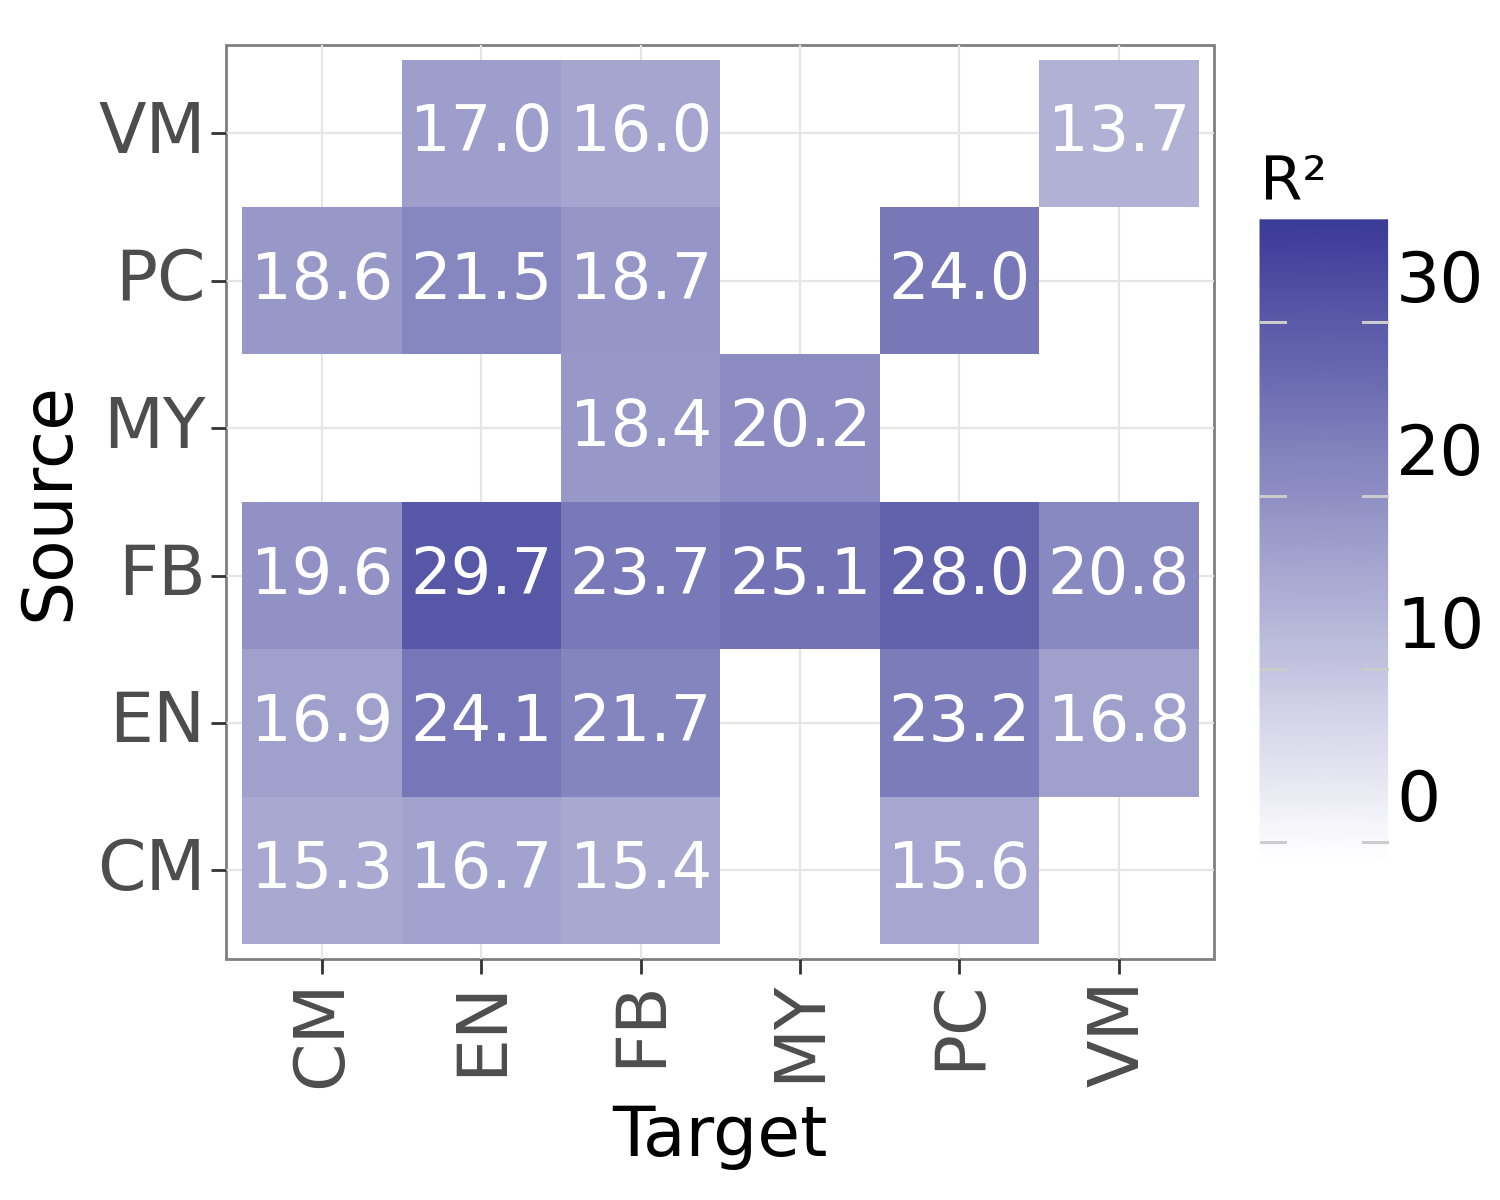

<Figure Size: (750 x 600)>

In [31]:
my_plot

In [32]:
my_plot.data.to_csv(os.path.join("..", "..", "figures", "source", "Fig3J.csv"))

In [28]:
variable_loadings.sort_values(by="Factor1", ascending=False, key=abs).head()

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size
7550,CALM1,RYR2,EN,EN,-2.276858,0.020469,-0.063264,0.588649,0.000644,0.064088,-0.067093,-0.506415,0.037442,0.003899,4.5
7107,CALM1,RYR2,EN,PC,-2.182584,0.030928,-0.020338,0.441816,-0.004921,0.057657,-0.101506,-0.791921,0.025498,-0.017191,4.5
5713,CALM1,RYR2,EN,VM,-2.150906,0.055402,-0.006581,1.024950,-0.024888,0.046141,-0.222724,-0.117545,0.044399,-0.027515,4.5
3096,LAMA2,ITGA1,FB,EN,-2.014466,0.223958,0.144533,0.029831,-0.016591,-0.006745,-0.021001,0.081882,0.055133,0.020562,4.5
8322,THBS4,CD36,PC,PC,-2.004401,0.058573,-0.648451,0.024032,-0.109650,-0.032997,-0.072330,0.050800,-0.006677,-0.030687,4.5


In [29]:
ct_int = variable_loadings[(variable_loadings['source']=='FB') & (variable_loadings['target']=='MY')]

In [30]:
# rank by absolute values of Factor 1
ct_int['rank'] = ct_int['Factor1'].rank(ascending=False)

In [31]:
ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(5)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank
4403,DCN,TLR2,FB,MY,-1.634593,0.013289,0.473593,-0.471355,-0.103770,-0.016930,-0.019692,-0.001094,-0.048802,-0.009248,4.5,472.0
4489,LAMA2,CD44,FB,MY,-1.548011,0.005623,0.288763,-0.093856,0.031966,-0.001981,0.023162,0.005503,0.117072,-0.000137,4.5,471.0
4494,LAMA2,ITGA9_ITGB1,FB,MY,-1.304513,0.045737,0.305208,0.706032,0.045294,0.005890,-0.040443,0.000695,-0.037070,0.048798,4.5,470.0
4304,CALM1,RYR2,FB,MY,-1.261051,0.008284,-0.065995,0.490779,0.019465,0.028727,-0.045797,-0.088683,-0.041174,-0.050560,4.5,469.0
4511,LAMC1,CD44,FB,MY,-1.192843,-0.013668,-0.035919,-0.383232,0.110058,-0.010133,0.006705,0.017493,0.091409,-0.028614,4.5,468.0


In [32]:

ct_int['name'] = ct_int['ligand_complex'] + ' -> ' + ct_int['receptor_complex']
# # keep name for only the top 5 by absolute values of Factor 1
# ct_names = ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(1)['name'].tolist()
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_names else '')
# keep top 1 according to rank
ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int.sort_values(by='rank', ascending=True).head(1)['name'].tolist() else '')
## keep name where ligand_complex=="LAMA2" and receptor_complex=="ITGA6_ITGB1" (top 3)
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['ligand_complex']=="LAMA2"]['name'].tolist() else '')
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['receptor_complex']=="ITGA6_ITGB1"]['name'].tolist() else '')

In [33]:
ct_int.sort_values("Factor1").tail(10)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
4477,IGF1,INSR,FB,MY,0.379531,0.415201,1.142819,0.142761,-0.025576,-0.006668,0.000145,-0.000866,0.104067,0.025243,4.5,10.0,
4542,NAMPT,INSR,FB,MY,0.390667,-0.008223,0.952940,0.617479,-0.054168,0.005046,0.038809,-0.017396,0.066415,0.014111,4.5,9.0,
4351,COL1A1,ITGA9_ITGB1,FB,MY,0.451111,-0.332032,-0.009476,1.503062,-0.009618,0.001731,-0.057044,0.005821,-0.019213,0.002423,4.5,8.0,
4596,SERPINE1,ITGB5,FB,MY,0.544498,-0.039285,0.303745,0.009164,-0.001933,0.005452,0.046986,-0.022577,-0.038100,0.010763,4.5,7.0,
4598,SERPINE1,PLAUR,FB,MY,0.635787,-0.147175,0.099467,-0.045498,-0.016462,-0.004946,0.314897,-0.005720,-0.020931,0.006076,4.5,6.0,
4435,FN1,PLAUR,FB,MY,0.690836,-1.291907,-0.019680,-0.136486,0.020091,-0.011274,0.108748,-0.002798,0.019371,-0.012797,4.5,5.0,
4352,COL1A2,CD36,FB,MY,0.744114,-1.343161,-0.040931,0.426870,-0.165290,-0.011689,0.009119,-0.008223,-0.026324,-0.009130,4.5,4.0,
4597,SERPINE1,LRP1,FB,MY,0.871139,-0.063192,0.072381,0.036503,-0.018294,-0.001493,0.255626,-0.012521,-0.046185,0.012576,4.5,3.0,
4345,COL1A1,CD36,FB,MY,0.889367,-1.242538,-0.229800,0.773520,-0.147675,0.000276,-0.027876,-0.018747,-0.000057,-0.004316,4.5,2.0,
4428,FN1,C5AR1,FB,MY,1.060510,-0.972949,-0.011801,-0.277630,0.013355,-0.001210,0.208397,-0.021257,-0.008797,-0.016129,4.5,1.0,FN1 -> C5AR1


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


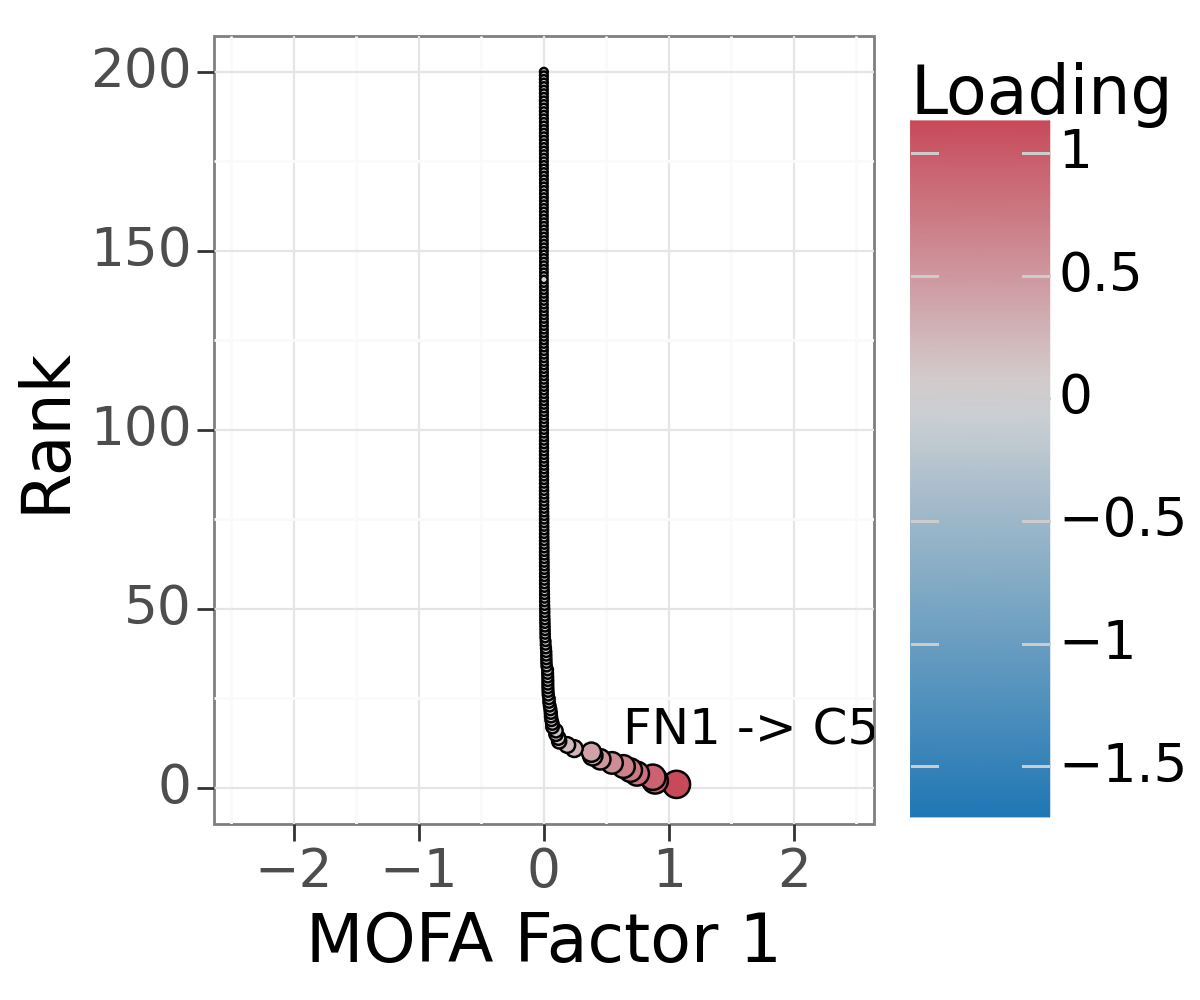

<Figure Size: (600 x 500)>

In [34]:
ct_int['size'] = ct_int['Factor1'].abs()
(
    p9.ggplot(ct_int) +
    p9.aes(x='Factor1', y='rank', fill='Factor1', size='size') +
    p9.geom_point() +
    p9.geom_text(p9.aes(label='name'), size=18, nudge_x=1, nudge_y=15) +
    p9.theme_bw(base_size=24) +
    p9.theme(figure_size=(6, 5)) +
    p9.scale_x_continuous(limits=(-2.4, 2.4)) +
    # scale rank to 0-200
    p9.scale_y_continuous(limits=(0, 200)) +
    p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0) +
    p9.labs(x='MOFA Factor 1', y='Rank', fill='Loading') +
    # hide size
    p9.guides(size=False)
)

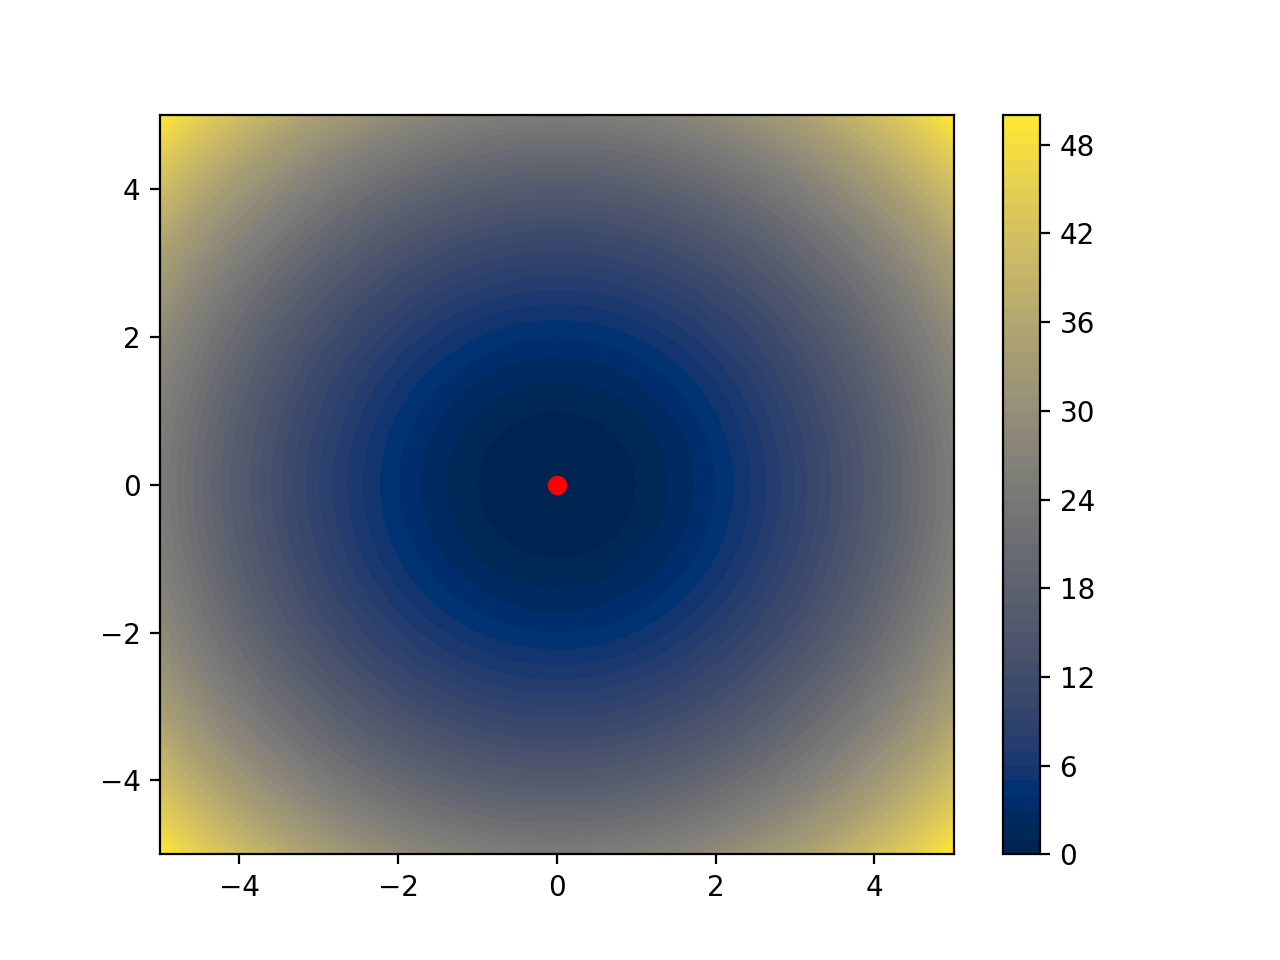

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def f(x, y):
    return x**2 + y**2

# Create a meshgrid of x and y values
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)

# Contour plot
cp = ax.contourf(X, Y, Z, 50, cmap=cm.cividis)
plt.colorbar(cp) # Add a colorbar to the plot

# Mark the global minimum
ax.plot(0, 0, 'ro') # 'ro' for red circle
